# Pytorch3D Tutorial

Contents of tutorial:
* Installing Pytorch3D on Colab
* Mesh Rendering
* Point cloud Rendering

More tutorials available: https://github.com/facebookresearch/pytorch3d

## Installing Pytorch3D


It will be much faster if you switch to GPU runtime (Runtime > Change runtime type > Hardware Accelerator > GPU).

In [156]:
# import os
# import sys
# import torch
# need_pytorch3d=False
# try:
#     import pytorch3d
# except ModuleNotFoundError:
#     need_pytorch3d=True
# if need_pytorch3d:
#     if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
#         # We try to install PyTorch3D via a released wheel.
#         pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
#         version_str="".join([
#             f"py3{sys.version_info.minor}_cu",
#             torch.version.cuda.replace(".",""),
#             f"_pyt{pyt_version_str}"
#         ])
#         !pip install fvcore iopath
#         !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#     else:
#         # We try to install PyTorch3D from source.
#         !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [157]:
# # Set up starter code
# !git clone https://github.com/learning3d/assignment1.git
# !mv assignment1/* .
# !pip install -r requirements.txt

Just for documentation, the following works flawlessly:

```
from pytorch3d.io import load_obj, load_objs_as_meshes
from pytorch3d.vis.plotly_vis import plot_scene

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1-line convenience loader (creates verts, faces, textures correctly)
meshes = load_objs_as_meshes(["data/cow.obj"], device=device)

# dummy camera
cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=torch.eye(3)[None], T=torch.tensor([[0, 0, 3.]]), fov=60, device=device)

fig = plot_scene({"subplot": {"cow": meshes, "cam": cameras}})
fig.show()                         # or fig.show(renderer="notebook")


```

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import pytorch3d
import pytorch3d.io
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.structures import Meshes
from tqdm.auto import tqdm

import starter.utils

In [2]:
# This should print True if you are using your GPU
print("Using GPU:", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

Using GPU: True


## Rendering a Mesh

To render a mesh, we need 3 components:

* A mesh to render
* A camera to render from
* A renderer (consisting of a rasterizer and shader)

### Setting up a mesh

In [3]:
vertices, face_props, text_props = pytorch3d.io.load_obj("data/cow.obj")
faces = face_props.verts_idx

In [4]:
# Alternatively, we can use the wrapper from the starter code to load a mesh.
vertices, faces = starter.utils.load_cow_mesh(path="data/cow.obj")

In [5]:
print("Vertices", vertices.shape)
print("Faces", faces.shape)

Vertices torch.Size([2930, 3])
Faces torch.Size([5856, 3])


In [6]:
print("vertices: ", vertices[0])
print("faces: ", faces[0])

faces.min(), faces.max()

vertices:  tensor([ 0.3488, -0.3350, -0.0832])
faces:  tensor([738, 734, 735])


(tensor(0), tensor(2929))

In [7]:
# All Pytorch3D elements need to be batched!
vertices = vertices.unsqueeze(0)  # 1 x N_v x 3
faces = faces.unsqueeze(0)  # 1 x N_f x 3

print("Vertices", vertices.shape)
print("Faces", faces.shape)

Vertices torch.Size([1, 2930, 3])
Faces torch.Size([1, 5856, 3])


In [8]:
texture_rgb = torch.ones_like(vertices) # N X 3
texture_rgb = texture_rgb * torch.tensor([0, 0, 1])
textures = pytorch3d.renderer.TexturesVertex(texture_rgb) # important
print(texture_rgb)
print(texture_rgb.shape)

tensor([[[0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.],
         ...,
         [0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.]]])
torch.Size([1, 2930, 3])


In [9]:
meshes = pytorch3d.structures.Meshes(
    verts=vertices, # batched tensor or a list of tensors
    faces=faces,
    textures=textures,
)

meshes = meshes.to(device)  # Move mesh to GPU

In [10]:
print(meshes.verts_padded().shape)
print(meshes.faces_padded().shape)

torch.Size([1, 2930, 3])
torch.Size([1, 5856, 3])


### Setting up a camera

In [11]:
R = torch.eye(3).unsqueeze(0)
T = torch.tensor([[0, 0, 3]])

In [12]:
# world -> view transforms
# view_T_world @ world = view

cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    fov=60,
    device=device,
)

In [13]:
cameras.get_camera_center()

tensor([[ 0.,  0., -3.]], device='cuda:0')

In [14]:
transform = cameras.get_world_to_view_transform()
transform.get_matrix()

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 3., 1.]]], device='cuda:0')

### Setting up a Renderer

Rasterizer: Given a pixel, which triangles correspond to it?

Shader: Given triangle, texture, lighting, etc, how should the pixel be colored?

In [15]:
image_size = 512

raster_settings = pytorch3d.renderer.RasterizationSettings(image_size=image_size)
rasterizer = pytorch3d.renderer.MeshRasterizer(
    raster_settings=raster_settings,
)
shader = pytorch3d.renderer.HardPhongShader(device=device)
renderer = pytorch3d.renderer.MeshRenderer(
    rasterizer=rasterizer,
    shader=shader,
)

In [16]:
# Alternatively, use the renderer wrapper
renderer = starter.utils.get_mesh_renderer(image_size=image_size, device=device)

### Render an image

In [17]:
image = renderer(meshes, cameras=cameras)
print(image.shape)

torch.Size([1, 512, 512, 4])


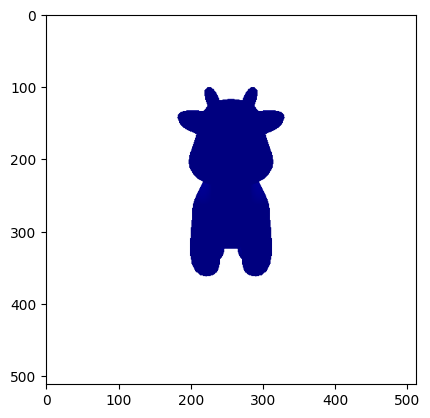

In [18]:
image = image[0].cpu().numpy()
plt.imshow(image)

The co-ordinate axes here following this convention:
X <-- ;
Y ^ ;
Z inwards

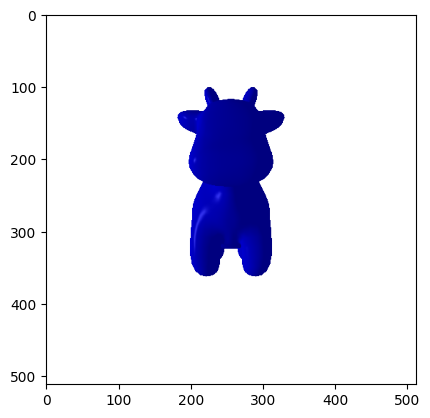

In [19]:
lights = pytorch3d.renderer.PointLights(location=[[10, 0, -3]], device=device)
image = renderer(meshes, cameras=cameras, lights=lights)
plt.imshow(image[0].cpu().numpy())

In [20]:
fig = plot_scene({
    "figure": {
        "Mesh": meshes,  
        "Camera": cameras,  
    }
    })

# fig.update_traces(
#     flatshading=True,                 # uniform colour per face
#     lighting=dict(ambient=0.3,        # keep original colour
#                   diffuse=0.0,        # kill Lambert shading
#                   specular=0.0), 
#     lightposition=dict(x=110, y=0, z=200),     # no glossy highlights
#     selector=dict(type="mesh3d")      # apply only to mesh traces
# )
fig.show()

### Common Rendering Problems

* Nothing is visible
    * Check Camera center
    * Check the Camera world_to_view transform. Try applying the transform to the origin or specific vertices of the mesh.
    * Use the Plotly visualization.
* Lights doesn't seem to do anything
    * Make sure there's no typo (must be `renderer(..., lights=lights)` and not `light=lights`)
    * Check the position of the light



### Transformations

2 ways to apply geometric operations:
* Move the mesh
* Move the camera

In [21]:
relative_rotation = pytorch3d.transforms.euler_angles_to_matrix(
    torch.tensor([0, np.pi/2, 0]), "XYZ"
)
relative_rotation

tensor([[-4.3711e-08,  0.0000e+00,  1.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
        [-1.0000e+00,  0.0000e+00, -4.3711e-08]])

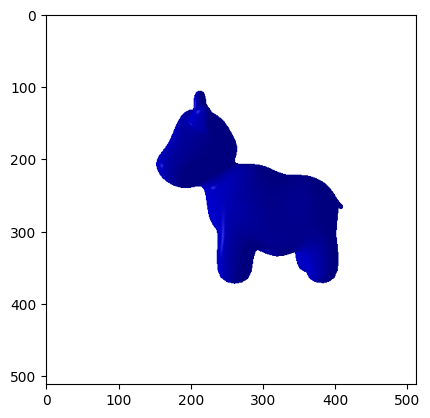

In [22]:
meshes2 = pytorch3d.structures.Meshes(
    verts=vertices @ relative_rotation,
    faces=faces,
    textures=textures,
).to(device)

image = renderer(meshes2, cameras=cameras, lights=lights)
plt.imshow(image[0].cpu().numpy())

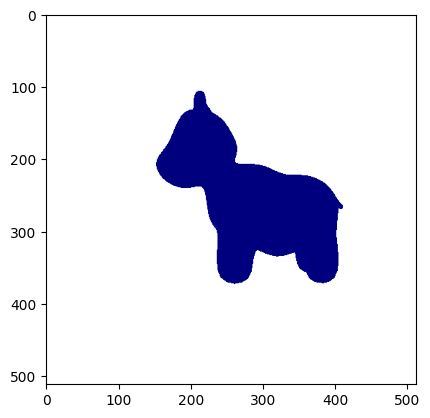

In [23]:
cameras2 = pytorch3d.renderer.FoVPerspectiveCameras(
    R=relative_rotation.unsqueeze(0),
    T=[[0, 0, 3]],
    device=device
)

image = renderer(meshes, cameras=cameras2, lights=lights)
plt.imshow(image[0].cpu().numpy())

In [24]:
transform = cameras2.get_world_to_view_transform()
transform.get_matrix()

tensor([[[-4.3711e-08,  0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.0000e+00,  0.0000e+00, -4.3711e-08,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  3.0000e+00,  1.0000e+00]]],
       device='cuda:0')

In [25]:
plot_scene({
    "Mesh1": {
        "Mesh": meshes,
        "Camera1": cameras,
        "Camera2": cameras2,
    },
    "Mesh2": {
        "Mesh": meshes2,
        "Camera1": cameras,
        "Camera2": cameras2,
    },
}, ncols=2)

In [26]:
num_views = 12
R, T = pytorch3d.renderer.look_at_view_transform(
    dist=3,
    elev=0,
    azim=np.linspace(-180, 180, num_views, endpoint=False),
)
print("R", R.shape)
print("T", T.shape)
many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)
images = renderer(meshes.extend(num_views), cameras=many_cameras, lights=lights)

R torch.Size([12, 3, 3])
T torch.Size([12, 3])


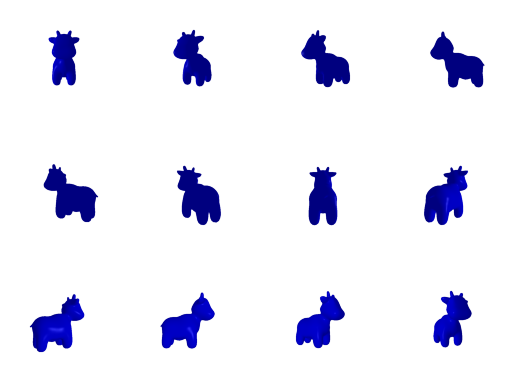

In [27]:
fig, axs = plt.subplots(3, 4)
axs = axs.flatten()
for i, image in enumerate(images):
    ax = axs[i]
    ax.imshow(image.cpu())
    ax.axis("off")

In [28]:
plot_scene({
    "All Views": {
        "Mesh": meshes,
        "Cameras": many_cameras,
    },
})

### Playing with Texture

In [29]:
texture_rgb = vertices.clone()
texture_rgb = (texture_rgb - texture_rgb.min()) / (texture_rgb.max() - texture_rgb.min())
texture_rgb /= texture_rgb.norm(dim=2, keepdim=True)
textures_rainbow = pytorch3d.renderer.TexturesVertex(texture_rgb.to(device))
meshes.textures = textures_rainbow

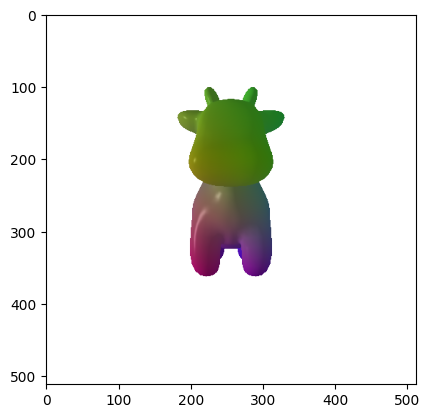

In [30]:
image = renderer(meshes, cameras=cameras, lights=lights)
plt.imshow(image[0].cpu().numpy())

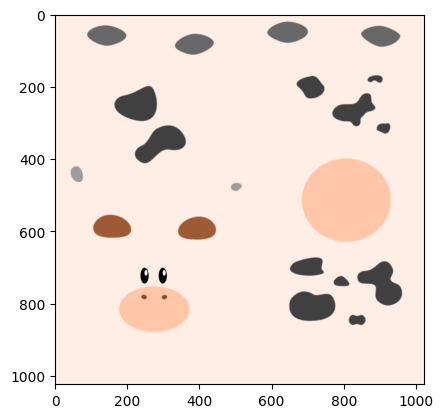

In [31]:
vertices, face_props, text_props = pytorch3d.io.load_obj("data/cow.obj")
faces = face_props.verts_idx
vertices = vertices.unsqueeze(0)
faces = faces.unsqueeze(0)
verts_uvs = text_props.verts_uvs
faces_uvs = face_props.textures_idx

texture_map = plt.imread("data/cow_texture.png")
plt.imshow(texture_map)

In [32]:
textures_uv = pytorch3d.renderer.TexturesUV(
    maps=torch.tensor([texture_map]),
    faces_uvs=faces_uvs.unsqueeze(0),
    verts_uvs=verts_uvs.unsqueeze(0),
).to(device)

/tmp/ipykernel_202196/2245936011.py:2: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)



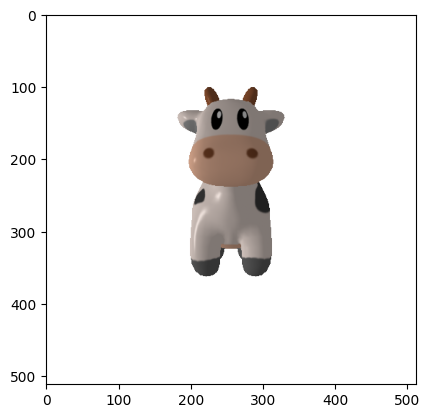

In [33]:
meshes.textures = textures_uv
image = renderer(meshes, cameras=cameras, lights=lights)
plt.imshow(image[0].cpu().numpy())

## Rendering Pointclouds

We will need:

* A point cloud
* A camera
* A point renderer

### Setting up Point Cloud

In [34]:
coords = torch.randn(1000, 3)
rgb = torch.ones_like(coords) * torch.tensor([0.7, 0.7, 1])

print("Coords:", coords.shape)
print("RGB:", rgb.shape)

Coords: torch.Size([1000, 3])
RGB: torch.Size([1000, 3])


In [35]:
pointcloud = pytorch3d.structures.Pointclouds(
    points=coords.unsqueeze(0),
    features=rgb.unsqueeze(0),
).to(device)

In [36]:
renderer = starter.utils.get_points_renderer(device=device, radius=0.03)

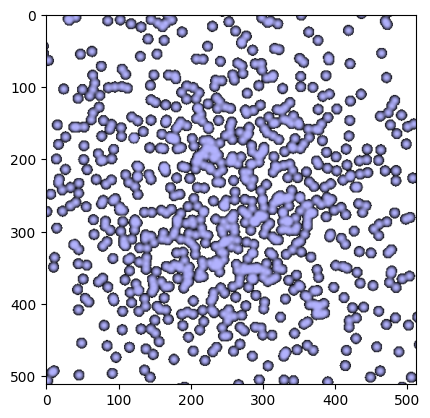

In [37]:
image = renderer(pointcloud, cameras=cameras)
plt.imshow(image[0].cpu())

In [38]:
plot_scene({
    "Pointcloud": {
        "Pointcloud": pointcloud,
        "Camera": cameras,
    },
})

In [39]:
rgb = coords.clone()
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

pointcloud = pytorch3d.structures.Pointclouds(
    points=coords.unsqueeze(0),
    features=rgb.unsqueeze(0),
).to(device)

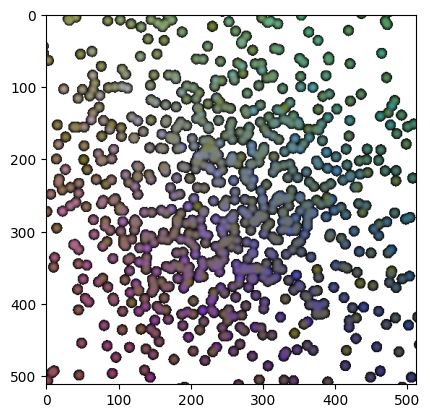

In [40]:
image = renderer(pointcloud, cameras=cameras)
plt.imshow(image[0].cpu())

### Rendering Parametric Functions

Equation of a sphere with radius $r$ with center $(x_0, y_0, z_0)$:

$$x = x_0 + r * \sin \theta \cos\phi$$
$$y = y_0 + r * \cos \theta $$
$$z = z_0 + r * \sin\theta \sin\phi$$

In [41]:
num_samples = 1000
r = 1
x_0 = 0
y_0 = 0
z_0 = 0

phi = torch.linspace(0, 2 * np.pi, num_samples)
theta = torch.linspace(0, 2 * np.pi, num_samples)
Phi, Theta = torch.meshgrid(phi, theta, indexing="ij")

print("Phi", Phi.shape)
print("Theta", Theta.shape)

Phi torch.Size([1000, 1000])
Theta torch.Size([1000, 1000])


In [42]:
x = x_0 + r * torch.sin(Theta) * torch.cos(Phi)
y = y_0 + r * torch.cos(Theta)
z = z_0 + r * torch.sin(Theta) * torch.sin(Phi)

In [43]:
points = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)
color = (points - points.min()) / (points.max() - points.min())

sphere_point_cloud = pytorch3d.structures.Pointclouds(
    points=[points], features=[color],
).to(device)

In [62]:
renderer = starter.utils.get_points_renderer(radius=0.01)

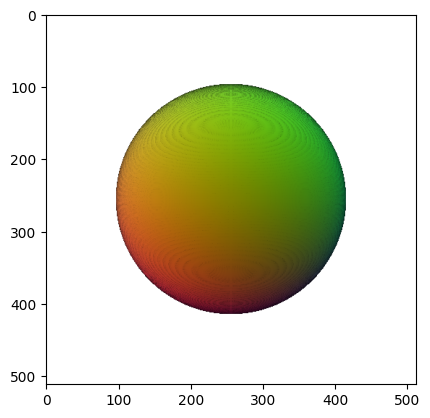

In [63]:
image = renderer(sphere_point_cloud, cameras=cameras)
plt.imshow(image[0].cpu())

In [64]:
plot_scene({
    "Pointcloud": {
        "Pointcloud": sphere_point_cloud,
        "Camera": cameras,
    },
})